In [15]:
import time
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [7]:
# Set up environment
import ale_py

gym.register_envs(ale_py)  # unnecessary but helpful for IDEs
env_name = 'Pong-v0'
env = gym.make(env_name, render_mode='rgb_array')
state_size = (84, 84, 1)  # Single frame for simplicity
action_size = env.action_space.n
buffer_size = 100000
batch_size = 64
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon

/home/bmartins/anaconda3/envs/rl_study/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


In [8]:
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return observation_frame.astype(float)

In [9]:
# Preprocess frame
def preprocess_frame(frame):
    """
    Convert frame to grayscale, crop, and normalize.
    Returns a (84x84) numpy array with values in [0, 1].
    """
    # Convert to grayscale
    frame = np.mean(frame, axis=2)
    
    # Crop the screen to focus on the playing area
    frame = frame[34:-16]
    
    # Normalize pixel values
    frame = frame / 255.0
    frame = frame[np.newaxis, ...]
    return frame 
    #return frame.reshape(state_size)

In [ ]:
# play the game using a random policy and render the frames in the notebook
obs, info = env.reset() 
obs = preprocess_frame(obs)
done = False
total_reward = 0
    
while not done:
    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)
    plt.imshow(obs) 
    plt.show()
    clear_output(wait=True)
    obs = preprocess_frame(obs)
    total_reward += reward
        
    if terminated or truncated:
        done = True
            
time.sleep(1)

env.close() 



KeyboardInterrupt: 

In [ ]:
# play the game with the UI using a random policy 
def play_random_policy(env, num_episodes=10):
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = env.action_space.sample()  # Random action
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward
        env.render()  # Render the environment
        time.sleep(1)
        env.close()

play_random_policy(env, num_episodes=3)

Episode 1: Total Reward: -20.0
Episode 2: Total Reward: -21.0
Episode 3: Total Reward: -21.0


In [4]:
# Build neural network model
class DQN(nn.Module):
    def __init__(self, input_shape, action_size):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=(8,8), stride=(4,4)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(4,4), stride=(2,2)),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the output size of conv layers
        self.conv_output_size = self._get_conv_output()
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.conv_output_size, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, action_size)
        )
    
    def _get_conv_output(self):
        """
        Helper method to get the output size of the convolutional layers.
        """
        # Create dummy input with correct shape: (batch_size, channels, height, width)
        # input_shape is (height, width, channels), so we need to permute
        #dummy_input = torch.randn(1, self.input_shape[2], self.input_shape[0], self.input_shape[1])
        dummy_input = torch.randn(1, self.input_shape[1], self.input_shape[2], self.input_shape[3])
        output = self.conv_layers(dummy_input)
        return output.size()[1]
    
    def forward(self, x):
        """
        Forward pass of the network.
        Converts input tensor (batch_size, height, width, channels) to 
        PyTorch's expected format (batch_size, channels, height, width).
        Returns Q-values for each action.
        """
        x = x.float() / 255.0
        # Permute dimensions to [batch_size, channels, height, width]
        #x = x.permute(0, 3, 1, 2)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [5]:
obs, _ = env.reset()
print(obs.shape)
state = preprocess_frame(obs)
state_tensor = torch.FloatTensor([state])
print(state_tensor.shape)
action_size = env.action_space.n
model = DQN(state_tensor.shape, action_size).float()
q_values = model(state_tensor)
action = 0
step = env.step(action)
len(step)
step[4]

/tmp/ipykernel_4446/396650518.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660061111189/work/torch/csrc/utils/tensor_new.cpp:204.)
  state_tensor = torch.FloatTensor([state])


(210, 160, 3)
torch.Size([1, 1, 160, 160])


{'lives': 0, 'episode_frame_number': 2, 'frame_number': 2}

In [6]:
env.observation_space.shape, state_tensor.shape

((210, 160, 3), torch.Size([1, 1, 160, 160]))

In [7]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)



In [ ]:
GAMMA = 0.99
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state, info = self.env.reset()
        #obs, info = env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([preprocess_frame(self.state)], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(preprocess_frame(self.state), action, reward, is_done, preprocess_frame(new_state))
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.ByteTensor(dones).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [17]:
def play_policy(env, net, device):
    obs, info = env.reset() 
    obs = preprocess_frame(obs)
    done = False
    total_reward = 0
        
    while not done:
        state_a = np.array([preprocess_frame(obs)], copy=False)
        state_v = torch.tensor(state_a).to(device)
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
        # do step in the environment
        obs, reward, terminated, truncated, info = env.step(action)
        plt.imshow(obs) 
        plt.show()
        clear_output(wait=True)
        obs = preprocess_frame(obs)
        total_reward += reward
            
        if terminated or truncated:
            done = True
                
    time.sleep(1)
    env.close() 

KeyboardInterrupt: 

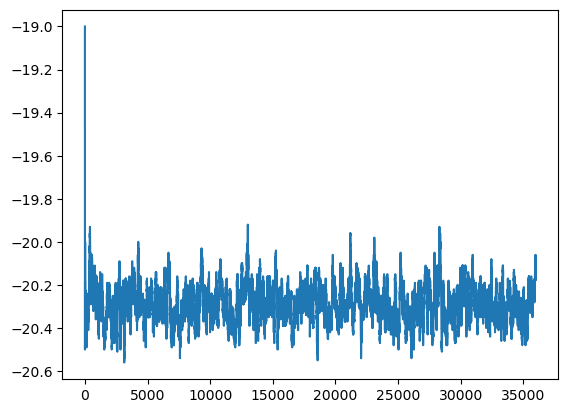

In [ ]:


print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env = gym.make(env_name)
base_path = "models/"

MEAN_REWARD_BOUND = 19.5
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 10**7
EPSILON_START = 1.0
EPSILON_FINAL = 0.02

obs, _ = env.reset()
state = preprocess_frame(obs)
state_tensor = torch.FloatTensor([state])

net = DQN(state_tensor.shape, env.action_space.n).to(device)
tgt_net = DQN(state_tensor.shape, env.action_space.n).to(device)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_mean_reward = None
args_reward = MEAN_REWARD_BOUND
reward_history = []

## add restart block here
fig,ax = plt.subplots(1,1)

while True:
    frame_idx += 1
    epsilon = EPSILON_START 
    #epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    reward = agent.play_step(net, epsilon, device=device)
    #clear_output()
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        reward_history.append(mean_reward)
        #print("%d: done %d games, mean reward %.3f, eps %.2f, speed %.2f f/s" % (frame_idx, len(total_rewards), mean_reward, epsilon, speed))
        if best_mean_reward is None or best_mean_reward < mean_reward:
            #torch.save(net.state_dict(), base_path + str(frame_idx) + "_" + env_name + "-best.dat")
            if best_mean_reward is not None:
                print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
            best_mean_reward = mean_reward
        if mean_reward > args_reward:
            print("Solved in %d frames!" % frame_idx)
#                fh_log.write("Solved in %d frames!\n" % frame_idx)
#                fh_log.flush()
            break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())
            ax.clear()
            ax.plot(reward_history)
            display(ax.figure)
            clear_output(wait=True)

            play_policy(env, net, device)  

            # play the game using the current policy

        
            
        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()